In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchmetrics import JaccardIndex
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np

In [2]:
test_seg = np.load('test_seg.npy')
train_seg = np.load('train_seg.npy')

In [3]:
class ImageMapDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        X = self.data[idx][0:2]
        y = self.data[idx][2]
        X = torch.from_numpy(X).float()
        y = torch.from_numpy(y).float()

        return X, y

In [4]:
batch_size = 64 
test_seg_dataset = ImageMapDataset(test_seg)
train_seg_dataset = ImageMapDataset(train_seg)
test_seg_dataloader = DataLoader(test_seg_dataset, batch_size=batch_size, shuffle=True)
train_seg_dataloader = DataLoader(train_seg_dataset, batch_size=batch_size, shuffle=True)

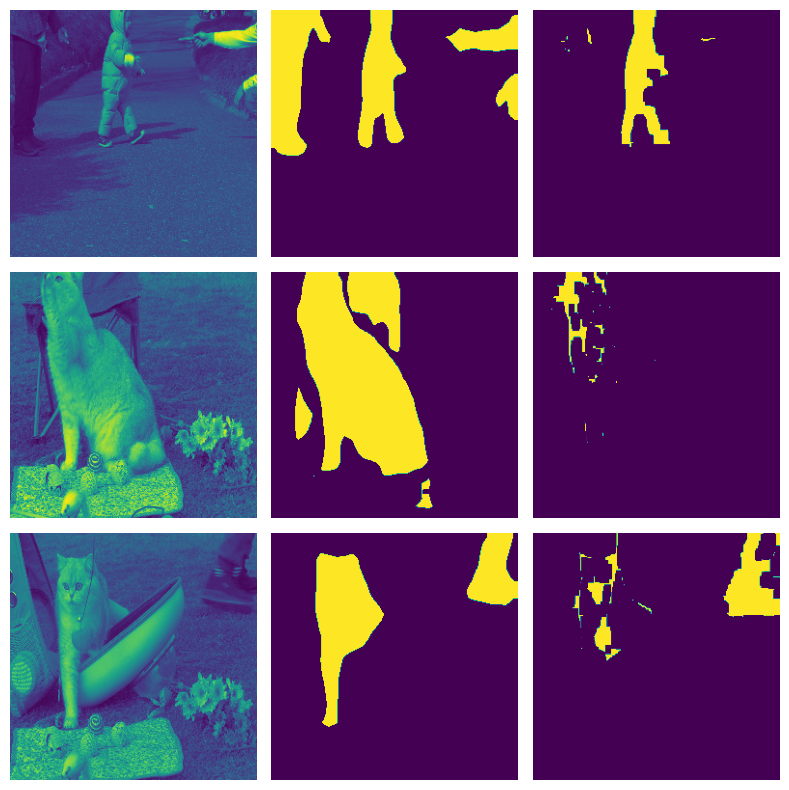

In [13]:
X_batch, Y_batch = next(iter(test_seg_dataloader))
plt.figure(figsize=(8, 8))
for i in range(3):
    plt.subplot(3, 3, 3*i + 1)
    plt.imshow(X_batch[i][0]) # grayscale sharp image
    plt.axis('off')  
    plt.subplot(3, 3, 3*i + 2)
    plt.imshow(X_batch[i][1]) # reverse DeepLabv3 backgroung class
    plt.axis('off')  
    plt.subplot(3, 3, 3*i + 3) # ground truth blur segmentation
    plt.imshow(Y_batch[i])
    plt.axis('off')  
plt.tight_layout()
plt.show()

In [5]:
class SegNet(nn.Module):
    def __init__(self, in_channels=2, out_channels=1):
        super().__init__()

        self.in_chn = in_channels
        self.out_chn = out_channels

        # VGG-16 architecture
        self.enc_conv01 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.enc_bn01 = nn.BatchNorm2d(64)
        self.enc_conv02 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.enc_bn02 = nn.BatchNorm2d(64)
        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=None, return_indices=True)

        self.enc_conv11 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_bn11 = nn.BatchNorm2d(128)
        self.enc_conv12 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.enc_bn12 = nn.BatchNorm2d(128)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=None, return_indices=True)

        self.enc_conv21 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_bn21 = nn.BatchNorm2d(256)
        self.enc_conv22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_bn22 = nn.BatchNorm2d(256)
        self.enc_conv23 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.enc_bn23 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=None, return_indices=True)

        self.enc_conv31 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.enc_bn31 = nn.BatchNorm2d(512)
        self.enc_conv32 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_bn32 = nn.BatchNorm2d(512)
        self.enc_conv33 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.enc_bn33 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=None, return_indices=True)

        # bottleneck
        self.bottleneck_conv0 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bottleneck_bn0 = nn.BatchNorm2d(512)
        self.bottleneck_conv1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bottleneck_bn1 = nn.BatchNorm2d(512)

        # decoder
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv01 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec_bn01 = nn.BatchNorm2d(512)
        self.dec_conv02 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dec_bn02 = nn.BatchNorm2d(512)
        self.dec_conv03 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dec_bn03 = nn.BatchNorm2d(256)

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv11 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dec_bn11 = nn.BatchNorm2d(256)
        self.dec_conv12 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dec_bn12 = nn.BatchNorm2d(256)
        self.dec_conv13 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_bn13 = nn.BatchNorm2d(128)

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv21 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dec_bn21 = nn.BatchNorm2d(128)
        self.dec_conv22 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn22 = nn.BatchNorm2d(64)

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2)
        self.dec_conv31 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dec_bn31 = nn.BatchNorm2d(64)
        self.dec_conv32 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e01 = F.relu(self.enc_bn01(self.enc_conv01(x)))
        e02 = F.relu(self.enc_bn02(self.enc_conv02(e01)))
        e0, id0 = self.pool0(e02)

        e11 = F.relu(self.enc_bn11(self.enc_conv11(e0)))
        e12 = F.relu(self.enc_bn12(self.enc_conv12(e11)))
        e1, id1 = self.pool1(e12)

        e21 = F.relu(self.enc_bn21(self.enc_conv21(e1)))
        e22 = F.relu(self.enc_bn22(self.enc_conv22(e21)))
        e23 = F.relu(self.enc_bn23(self.enc_conv23(e22)))
        e2, id2 = self.pool2(e23)

        e31 = F.relu(self.enc_bn31(self.enc_conv31(e2)))
        e32 = F.relu(self.enc_bn32(self.enc_conv32(e31)))
        e33 = F.relu(self.enc_bn33(self.enc_conv33(e32)))
        e3, id3 = self.pool3(e33)

        # bottleneck
        b0 = F.relu(self.bottleneck_bn0(self.bottleneck_conv0(e3)))
        b1 = F.relu(self.bottleneck_bn1(self.bottleneck_conv1(b0)))

        # decoder
        d00 = self.upsample0(b1, id3)
        d01 = F.relu(self.dec_bn01(self.dec_conv01(d00)))
        d02 = F.relu(self.dec_bn02(self.dec_conv02(d01)))
        d03 = F.relu(self.dec_bn03(self.dec_conv03(d02)))

        d10 = self.upsample1(d03, id2)
        d11 = F.relu(self.dec_bn11(self.dec_conv11(d10)))
        d12 = F.relu(self.dec_bn12(self.dec_conv12(d11)))
        d13 = F.relu(self.dec_bn13(self.dec_conv13(d12)))

        d20 = self.upsample2(d13, id1)
        d21 = F.relu(self.dec_bn21(self.dec_conv21(d20)))
        d22 = F.relu(self.dec_bn22(self.dec_conv22(d21)))

        d30 = self.upsample3(d22, id0)
        d31 = F.relu(self.dec_bn31(self.dec_conv31(d30)))
        d32 = self.dec_conv32(d31)

        return d32

In [6]:
model = SegNet().cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
metric = JaccardIndex(threshold=0.5, task="binary", average='none').cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ckpt_path = './segmentation_checkpoints'
epochs = 10

In [7]:
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device, metric, ckpt_path):
    train_losses = []
    valid_losses = []
    train_metrics = []
    valid_metrics = []
    best_val_loss = float('inf')
    for epoch in tqdm(range(epochs)):
        model, train_loss, train_score = train_epoch(model, optimizer, criterion, train_dataloader, metric, device)
        model, valid_loss, valid_score = evaluate_epoch(model, criterion, valid_dataloader, metric, device)
        print(f'Epoch {epoch}:\tloss\tmetric')
        print(f'train\t{train_loss}\t{train_score}')
        print(f'valid\t{valid_loss}\t{valid_score}')
        train_losses.append(train_loss.cpu().detach().numpy())
        valid_losses.append(valid_loss.cpu().detach().numpy())
        train_metrics.append(train_score.cpu().detach().numpy())
        valid_metrics.append(valid_score.cpu().detach().numpy())

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(len(train_losses))), train_losses, label = 'train loss')
    ax1.plot(list(range(len(valid_losses))), valid_losses, label = 'val loss')
    ax2.plot(list(range(len(train_metrics))), train_metrics, label = 'train metric')
    ax2.plot(list(range(len(valid_metrics))), valid_metrics, label = 'val metric')
    ax1.set_title("Loss")
    ax2.set_title("Metric")
    ax1.legend()
    plt.show()

    if valid_loss < best_val_loss:
            best_val_loss = valid_loss
            torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_best_val_loss.pt')

    torch.save(model.state_dict(), f'{ckpt_path}/epoch_{epoch}_val_iou.pt')

    statistics = {'train_losses': train_losses,
                  'valid_losses': valid_losses,
                  'train_metrics': train_metrics,
                  'valid_metrics': valid_metrics}
    return model, statistics


def train_epoch(model, optimizer, criterion, train_dataloader, metric, device):

    model.train()

    epoch_loss = 0
    epoch_score = 0

    for  X_batch, Y_batch in train_dataloader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        for i in range(len(X_batch)):
            X = X_batch[i].view(1, 2, 256, 256)
            y = Y_batch[i].view(1, 1, 256, 256)

            optimizer.zero_grad()

            pred = model(X)
            loss = criterion(pred, y)
            score = metric(torch.round(pred), torch.round(y))
            loss.backward()

            optimizer.step()

            epoch_loss += loss
            epoch_score += score

    avg_loss = epoch_loss/len(train_dataloader)
    avg_score = epoch_score/len(train_dataloader)

    return model, avg_loss, avg_score

def evaluate_epoch(model, criterion, valid_dataloader, metric, device):

     model.eval()

     epoch_loss = 0
     epoch_score = 0

     with torch.no_grad():
        for X_batch, Y_batch in valid_dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            for i in range(len(X_batch)):
                X = X_batch[i].view(1, 2, 256, 256)
                y = Y_batch[i].view(1, 1, 256, 256)

                pred = model(X)
                loss = criterion(pred, y)
                score = metric(torch.round(pred), torch.round(y))

                epoch_loss += loss
                epoch_score += score

     avg_loss = epoch_loss/len(valid_dataloader)
     avg_score = epoch_score/len(valid_dataloader)

     return model, avg_loss, avg_score

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0:	loss	metric
train	15.317378044128418	15.158845901489258
valid	12.609257698059082	8.759971618652344
Epoch 1:	loss	metric
train	14.424996376037598	19.234952926635742
valid	12.44604778289795	12.607516288757324
Epoch 2:	loss	metric
train	13.112099647521973	21.86513900756836
valid	12.502531051635742	13.670199394226074
Epoch 3:	loss	metric
train	12.136897087097168	23.73013687133789
valid	12.976282119750977	6.152539253234863
Epoch 4:	loss	metric
train	11.273375511169434	25.854942321777344
valid	14.217873573303223	9.449953079223633
Epoch 5:	loss	metric
train	10.514949798583984	27.925113677978516
valid	15.2566499710083	9.427929878234863
Epoch 6:	loss	metric
train	9.995429992675781	29.349645614624023
valid	17.11477279663086	7.80259370803833
Epoch 7:	loss	metric
train	9.587488174438477	30.400739669799805
valid	14.032027244567871	14.530214309692383
Epoch 8:	loss	metric
train	9.001770973205566	31.756258010864258
valid	15.851767539978027	8.70335578918457
Epoch 9:	loss	metric
train	8.6468420

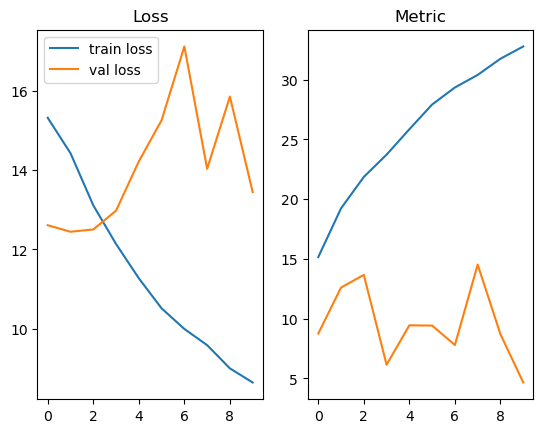

In [8]:
model, statistics = train(model, optimizer, criterion, epochs, train_seg_dataloader, test_seg_dataloader, device, metric, ckpt_path)

In [9]:
torch.save(model, 'seg_model.pth')

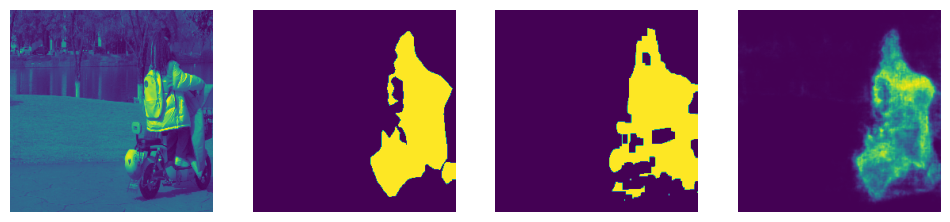

In [101]:
X_batch, Y_batch = next(iter(test_seg_dataloader))
X_batch = X_batch.cuda()
Y_batch = Y_batch.cuda()
output = torch.sigmoid(model(X_batch[0].view(1, 2, 256, 256)))
output = output.detach().cpu().numpy()
plt.figure(figsize = (12, 9))
plt.subplot(1, 4, 1)
plt.imshow(X_batch[0][0].cpu()) # grayscal sharp image
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(X_batch[0][1].cpu()) # DeepLabv3 background class
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(Y_batch[0].cpu()) # ground truth blur segmentation
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(output[0][0]) # predicted blur segmentation
plt.axis('off')
plt.show()